In [1]:
# Import relevant packages
import pymaid
import seaborn as sns
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
import sys
sys.path.insert(0,'Users/brandon/Documents/Bootcamp2019')
import CATMAID_CRED


In [2]:
# Initialize CATMAID
myInstance = CATMAID_CRED.CATMAID_CRED()

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


In [3]:
# Read in some skeleton data for the dbd neuron as a pandas dataframe and look at the general structure of the dataframe using the .head function
treenode_table = pd.read_csv('/Users/brandon/documents/Bootcamp2019/treenodes.csv')
print(treenode_table.shape)
treenode_table.head(5)

(711, 13)


,Unnamed: 0,skeleton_id,treenode_id,parent_node_id,confidence,x,y,z,radius,creator,last_edited,reviewers,tags
0,0,6195521,6196689,6196688.0,5,49479.2,74457.2,122850.0,-1.0,albert,2014-04-08 18:03:15+00:00,"['aref', 'akira']",[]
1,1,6195521,13804384,13804385.0,5,48142.2,75547.8,123250.0,-1.0,aref,2014-06-25 21:29:05+00:00,"['aref', 'akira']",[]
2,2,6195521,13776295,13804396.0,5,47830.6,75475.6,123150.0,-1.0,aref,2014-06-25 21:29:05+00:00,"['aref', 'akira']",[]
3,3,6195521,13804386,13776295.0,5,48161.2,75498.4,123150.0,-1.0,aref,2015-04-16 22:58:37+00:00,"['aref', 'akira']",[]
4,4,6195521,13804396,13804397.0,5,48461.4,75205.8,123100.0,-1.0,aref,2014-06-25 21:29:05+00:00,"['aref', 'akira']",[]


In [4]:
# Lets make sure we know what we are looking at.  We imported only one neuron.  Neurons in CATAMID are each given a unique identifier called a skeleton ID.  
# First, we can make sure we only have a single neuron in our dataframe by making sure we only have one skeleton ID present
neuron_count = pd.unique(treenode_table.skeleton_id)
print(len(neuron_count))

# Next, lets see how big our neuron is.  Each node of a skeleton is given a unique treenode ID.  We can count the number of treenode_IDs to get a rough idea of how big the neuron is
sk_node_count = pd.unique(treenode_table.treenode_id)
print(len(sk_node_count))

1
711


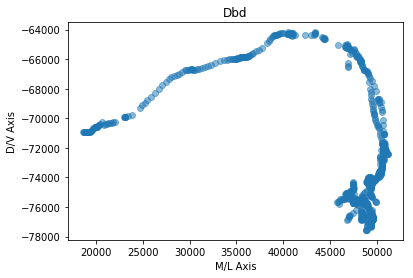

In [5]:
# The nice thing about dataframes is that we can use intuitive labels to index data.  For example, if we want to see what the neuron looks like,
# we can extract the coordinates of the neurons treenodes and plot them.  

plt.scatter(treenode_table.x, treenode_table.y*-1 , alpha=0.5)
plt.title('Dbd')
plt.xlabel('M/L Axis')
plt.ylabel('D/V Axis')
plt.show()

In [6]:
# We can also do a bit more complex indexing.  If, for example, we want to index based on location rather than the labels, we use .iloc
print(treenode_table.iloc[0:5,:])

# We can even combine the two and index with both
print(treenode_table.loc[:5,["x", "y", "z"]])

   Unnamed: 0  skeleton_id  treenode_id  parent_node_id  confidence        x  \
0           0      6195521      6196689       6196688.0           5  49479.2   
1           1      6195521     13804384      13804385.0           5  48142.2   
2           2      6195521     13776295      13804396.0           5  47830.6   
3           3      6195521     13804386      13776295.0           5  48161.2   
4           4      6195521     13804396      13804397.0           5  48461.4   

         y         z  radius creator                last_edited  \
0  74457.2  122850.0    -1.0  albert  2014-04-08 18:03:15+00:00   
1  75547.8  123250.0    -1.0    aref  2014-06-25 21:29:05+00:00   
2  75475.6  123150.0    -1.0    aref  2014-06-25 21:29:05+00:00   
3  75498.4  123150.0    -1.0    aref  2015-04-16 22:58:37+00:00   
4  75205.8  123100.0    -1.0    aref  2014-06-25 21:29:05+00:00   

           reviewers tags  
0  ['aref', 'akira']   []  
1  ['aref', 'akira']   []  
2  ['aref', 'akira']   []  
3  [

In [7]:
# Now that we have a bit of an understanding of how pandas dataframes work, we can use a similar logic to start working with more complicated data and packages.
# The pymaid package was designed for working with skeletonized neuronal data generated in CATMAID.  CATMAID deals in a file format called JSONs.  Pymaid can either
# interface directly with CATMAID, or read in JSON files which contain relevant data for neurons.  For this example, we will use JSON files.

with open('demo_data.json', 'r') as f:
    json_neurons = json.load(f)

str_neurons = json.dumps(json_neurons)
nl = pymaid.json2neuron(str_neurons)

In [8]:
# Now that we have a neuron list, we can explore how they are structured.  To start, lets just look at a summary
nl.summary


<bound method CatmaidNeuronList.summary of <class 'pymaid.core.CatmaidNeuronList'> of 8 neurons 
   neuron_name skeleton_id  n_nodes  n_connectors  n_branch_nodes  n_end_nodes  \
0     dbd_a1r     6195521      711            80              29           35   
1    A08a_a2l    19810511     1824           153             127          140   
2     dbd_a2r    13876816      472            32              32           38   
3     dbd_a2l    13883895      721            29              30           33   
4    A08a_a1l    12820537     1993           171             152          166   
5     dbd_a1l    13671419      639            80              27           29   
6    A08a_a2r    18435548     1936           176             144          154   
7    A08a_a1r    19806174     2604           262             215          234   

   open_ends  cable_length review_status   soma  
0          2    116.514086            NA  False  
1          1    240.598635            NA   True  
2         38     77.63

   connector_id  relation skeleton_id  treenode_id      x      y       z
0      62174518         0     6195521     14783812  47950  65975  118000
1       2708312         0     6195521      2708344  49806  74259  122600
2       6196395         0     6195521      6196369  50745  71880  120200
3       6196531         0     6195521      6196493  50437  72397  119700
4       2717848         0     6195521      6196568  50631  73233  120900
5       6196571         0     6195521      6196556  50509  72933  120800
6       6196590         0     6195521      6196589  50608  73195  121050
7       6196614         0     6195521      6196613  50464  72986  121100
8       6197280         0     6195521      6197271  50266  68840  117700
9       6197289         0     6195521      6197271  50080  68578  117700


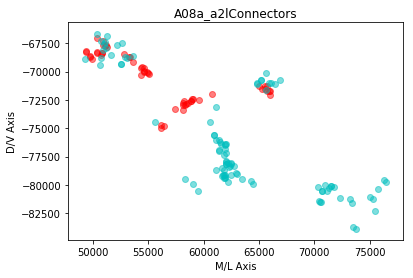

In [9]:
# This summary is a dataframe, but the neuron list itself is a bit more complicated.  It stores a much larger amount of data than what the summary is showing.
# For example, the neuron list stores all of the synapse locations for all of the neurons.  
print(nl.connectors.head(10))

# Whlie these data structures are a bit more complicated, we can think about them, and index them in the same way.  Let's combine a few things to plot the input and output sites for a single neuron.
# Notice the column 'relation'.  This column tells us if the connector is for a pre or post synaptic site.  If we index based on this column, we can separate inputs and outputs.  Syntax is 0 for presynapses, 1 for postsynapses.
plt.scatter(nl[1].connectors.x[nl[1].connectors.relation == 0], nl[1].connectors.y[nl[1].connectors.relation == 0]*-1 , alpha=0.5,c = 'r')
plt.scatter(nl[1].connectors.x[nl[1].connectors.relation == 1], nl[1].connectors.y[nl[1].connectors.relation == 1]*-1 , alpha=0.5, c = 'c')
plt.title(nl[1].neuron_name + 'Connectors')
plt.xlabel('M/L Axis')
plt.ylabel('D/V Axis')
plt.show()

INFO  : Retrieving 1 treenode table(s)... (pymaid)
INFO  : 1824 treenodes retrieved. Creating table... (pymaid)


  skeleton_id treenode_id parent_node_id confidence        x        y       z  \
0    19810511    10434535       17136288          5  62046.4    79249  138050   
1    19810511    11720917       24915661          5  51258.2  67022.5  133400   
2    19810511    12214226       24916283          5  49413.3  68413.3  136300   
3    19810511    13293962       17134404          5    51338    68609  134300   
4    19810511    13295894       17137630          5  65500.6  71181.6  135900   

  radius creator               last_edited  reviewers            tags  
0     -1   akira 2018-01-26 13:39:03+00:00  [avinash]  [not a branch]  
1     -1    aref 2018-01-25 15:15:35+00:00  [avinash]          [ends]  
2     -1    aref 2018-01-26 18:06:38+00:00  [avinash]              []  
3     -1   akira 2018-01-26 13:23:58+00:00  [avinash]              []  
4     -1   akira 2018-01-25 15:15:35+00:00  [avinash]              []  


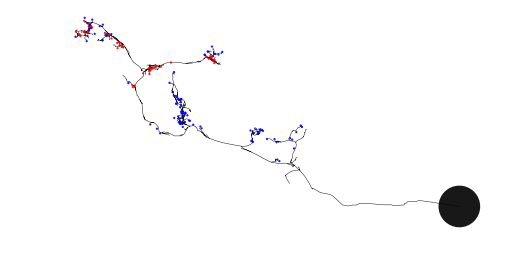

In [10]:
#  Now that we have a general idea of how the data is organized, we can do some more complicated plotting.  While a scatterplot of the treenodes is sort of useful for visualization, we can do far more complicated things if we think about
# the treenodes as part of a graph structure.  That is, if we consider the relationship between each of them.  
treenode_table = pymaid.get_treenode_table(nl[1])
print(treenode_table.head(5))
# If we look at the treenode table, we see the column with the treenode ids, and another column called parent_node_ids.  These two columns provide the relationship between one treenode and another, and allows us to 
# build a connected graph representation of the neuron.  We won't go into how exactly to do that today, but we can plot the graph representation of the neuron.  Additionally, we can add the synapses to the same plot.
fig, ax = nl[1].plot2d(color='k',connectors=True,cn_size=5)


In [ ]:
# The reason using graph structures to represent neurons is useful is because we can then do things like measure geodesic distances between points, cut neurons at different places, segment neurons into meaningful fragments,
# and build anatomically enriched wiring diagrams. To demonstrate this, lets cut A08a somewhere.

# First, we need to make sure the graph is directed towards a meaninful point so that if we cut it, we will get the pieces we want.  The best option is to reroot the graph at the soma.  

nl[1].reroot(nl[1].soma, inplace=True)
# Next we need to get the treenode IDs for this neuron in order to get a cut point
tn = pymaid.get_treenode_table(nl[1])
# Now cut the neuron using the cut_neuron function and plot the results.
cut = pymaid.cut_neuron(nl[1], tn.treenode_id[400])
fig, ax = pymaid.plot2d(cut, connectors=True, linewidth=1.5, cn_size = 15)
fig, ax = pymaid.plot2d(cut[0], connectors=True, linewidth=1.5, cn_size = 15)
fig, ax = pymaid.plot2d(cut[1], connectors=True, linewidth=1.5, cn_size = 15)

# You can imagine the possibilities of using these tools to look at compartmentalization of inputs, morphological features of different pieces of a neuron, and more.

In [ ]:
# Now that we know some basics about plotting and morphology, we can turn our attention to connectivity.  A simple way to do this is to generate a connectivity matrix between the neurons in our dataset.
neuron_adj = pymaid.adjacency_matrix(nl)
g = sns.heatmap(neuron_adj, square=True)
g.set_yticklabels(nl.neuron_name, rotation=0, fontsize=14)
g.set_xticklabels(nl.neuron_name, rotation=90, fontsize=14)
plt.show()



{'error': "User 'brandon' with ID 88 does not have the required permissions in project 1",
 'detail': 'Traceback (most recent call last):\n  File "/opt/catmaidL1/django/env/lib/python3.6/site-packages/django/core/handlers/base.py", line 124, in _get_response\n    response = wrapped_callback(request, *callback_args, **callback_kwargs)\n  File "/usr/lib/python3.6/contextlib.py", line 52, in inner\n    return func(*args, **kwds)\n  File "/opt/catmaidL1/django/applications/catmaid/history.py", line 63, in wrapped_f\n    result = f(*args, **kwargs)\n  File "/opt/catmaidL1/django/applications/catmaid/control/authentication.py", line 215, in inner_decorator\n    raise PermissionError(msg)\ncatmaid.control.authentication.PermissionError: User \'brandon\' with ID 88 does not have the required permissions in project 1\n',
 'type': 'PermissionError',
 'meta': None}